# Initial Experiments w Hierarchical Attention Mechanisms for External Memory

## Data

Model a "language modeling" task of predicting the next "word" in terms of a hidden Markov models.

$$
\begin{align*}
\mathcal{M} &= \{(x^{(t)}, y^{(t)})\}_{t \in [n_m]}\\
x^{(t)} &= (x_1^{(t)}, \ldots, x_l^{(t)})\\
y^{(t)} &= (y_1^{(t)}, \ldots, y_l^{(t)}) = (x_2^{(t)}, \ldots, x_{l+1}^{(t)})\\
\end{align*}
$$

where $x_i^{(t)}$ come from a hidden markov model.
$$
\begin{align*}
z_1^{(t)} &\sim \mu, z_{i+1}^{(t)} \sim P(\cdot | z_i^{(t)})\\
x_i^{(t)} &\sim O(\cdot | z_i^{(t)})
\end{align*}
$$

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.keras import TqdmCallback

import sys;sys.path.append('..')
import utils

## Generate Data

In [129]:
num_loops = 4
loop_length = 6 # for now, fixed length
num_notes = 6 # size of observation space

state_transition_edges = []

for l in range(num_loops):
    for s in range(loop_length):
        state_transition_edges.append((f's{l}{s}', f's{l}{(s+1)%loop_length}'))

    # NOTE: this adds connections between loops
    # for l2 in range(num_loops):
    #     state_transition_edges.append((f's{l}0', f's{l2}0'))

In [131]:
graph = nx.DiGraph(state_transition_edges)
states = list(graph.nodes())
state_to_idx = {s: i for i, s in enumerate(states)}
idx_to_state = {i: s for i, s in enumerate(states)}

emissions = [f'o{i}' for i in range(num_notes)]
idx_to_emission = {i: o for i,o in enumerate(emissions)}
emission_to_idx = {o: i for i,o in enumerate(emissions)}

In [132]:
state_transition_matrix = np.array(nx.adjacency_matrix(graph, nodelist=state_to_idx.keys()).todense())
state_transition_matrix = state_transition_matrix / np.sum(state_transition_matrix, axis=0)[:, np.newaxis]

/var/folders/86/rz4f689d2sb1ld1x196j98zm0000gn/T/ipykernel_1198/216198539.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  state_transition_matrix = np.array(nx.adjacency_matrix(graph, nodelist=state_to_idx.keys()).todense())


In [133]:
emissions_dict = {s: idx_to_emission[np.random.randint(num_notes)] for s in states}
emissions_dict

{'s00': 'o1',
 's01': 'o3',
 's02': 'o5',
 's03': 'o3',
 's04': 'o5',
 's05': 'o3',
 's10': 'o5',
 's11': 'o0',
 's12': 'o1',
 's13': 'o0',
 's14': 'o5',
 's15': 'o0',
 's20': 'o3',
 's21': 'o2',
 's22': 'o1',
 's23': 'o2',
 's24': 'o2',
 's25': 'o5',
 's30': 'o2',
 's31': 'o0',
 's32': 'o2',
 's33': 'o4',
 's34': 'o2',
 's35': 'o5'}

In [134]:
emissions_matrix = np.zeros((len(states), num_notes))
for i, s in enumerate(states):
    emissions_matrix[i, emission_to_idx[emissions_dict[s]]] = 1

ImportError: requires pygraphviz http://pygraphviz.github.io/

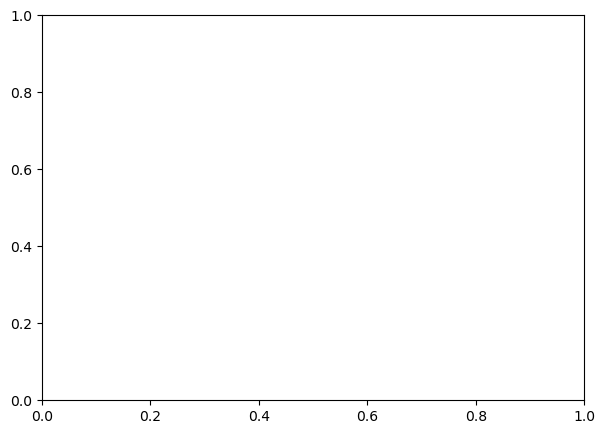

In [135]:
fig, ax = plt.subplots(figsize=(7,5))
nx.draw_networkx(graph, with_labels=True, labels=emissions_dict,
    pos=nx.nx_agraph.graphviz_layout(graph, prog='circo'),
    node_color=color_map, ax=ax, **options)
ax.set_title('notes (emissions)');

In [136]:
def sample_hmm(transition_matrix, emissions_matrix, initial_state, num_steps):
    current_state = initial_state
    states_seq = [current_state]
    emissions_seq = [np.random.choice(emissions, p=emissions_matrix[state_to_idx[current_state], :])]

    for i in range(num_steps-1):
        probabilities = transition_matrix[state_to_idx[current_state], :]
        next_state = np.random.choice(states, p=probabilities)
        states_seq.append(next_state)
        current_state = next_state
        emissions_seq.append(np.random.choice(emissions, p=emissions_matrix[state_to_idx[current_state], :]))
    return states_seq, emissions_seq

In [137]:
mem_seq_len = loop_length + 1
input_seq_len = 2*loop_length

mem_seq_initial_states = [f's{l}0' for l in range(num_loops)]
input_seqs_initial_states = [f's{l}0' for l in range(num_loops)]

train_seqs = np.array([sample_hmm(state_transition_matrix, emissions_matrix, initial_state, input_seq_len+1) for initial_state in input_seqs_initial_states])
train_state_seqs, train_emissions_seqs = train_seqs[:, 0, :], train_seqs[:, 1, :]
train_seqs_x = train_emissions_seqs[:, :-1]
train_seqs_y = train_emissions_seqs[:, 1:]

test_seqs = np.array([sample_hmm(state_transition_matrix, emissions_matrix, initial_state, input_seq_len+1) for initial_state in input_seqs_initial_states])
test_state_seqs, test_emissions_seqs = test_seqs[:, 0, :], test_seqs[:, 1, :]
test_seqs_x = test_emissions_seqs[:, :-1]
test_seqs_y = test_emissions_seqs[:, 1:]


mem_seqs = np.array([sample_hmm(state_transition_matrix, emissions_matrix, initial_state, mem_seq_len + 1) for initial_state in mem_seq_initial_states])
mem_seqs = np.repeat(np.expand_dims(mem_seqs, axis=0), axis=0, repeats=len(train_seqs))
mem_state_seqs, mem_emissions_seqs = mem_seqs[:, :, 0, :], mem_seqs[:, :, 1, :]
mem_seqs_x = mem_emissions_seqs[:, :, :-1]
mem_seqs_y = mem_emissions_seqs[:, :, 1:]


In [138]:
print(f'train_seqs_x.shape: {train_seqs_x.shape}; train_seqs_y.shape: {train_seqs_y.shape}') # shape [batch_size, seq_len]
print(f'mem_seqs_x.shape: {mem_seqs_x.shape}; mem_seqs_y.shape: {mem_seqs_y.shape}') # shape [batch_size, num_mem_seqs, mem_seq_len]

train_seqs_x.shape: (4, 12); train_seqs_y.shape: (4, 12)
mem_seqs_x.shape: (4, 4, 7); mem_seqs_y.shape: (4, 4, 7)


In [139]:
mem_state_seqs[0]

array([['s00', 's01', 's02', 's03', 's04', 's05', 's00', 's01'],
       ['s10', 's11', 's12', 's13', 's14', 's15', 's10', 's11'],
       ['s20', 's21', 's22', 's23', 's24', 's25', 's20', 's21'],
       ['s30', 's31', 's32', 's33', 's34', 's35', 's30', 's31']],
      dtype='<U3')

In [140]:
mem_seqs_x[0]

array([['o1', 'o3', 'o5', 'o3', 'o5', 'o3', 'o1'],
       ['o5', 'o0', 'o1', 'o0', 'o5', 'o0', 'o5'],
       ['o3', 'o2', 'o1', 'o2', 'o2', 'o5', 'o3'],
       ['o2', 'o0', 'o2', 'o4', 'o2', 'o5', 'o2']], dtype='<U3')

In [141]:
train_seqs_x

array([['o1', 'o3', 'o5', 'o3', 'o5', 'o3', 'o1', 'o3', 'o5', 'o3', 'o5',
        'o3'],
       ['o5', 'o0', 'o1', 'o0', 'o5', 'o0', 'o5', 'o0', 'o1', 'o0', 'o5',
        'o0'],
       ['o3', 'o2', 'o1', 'o2', 'o2', 'o5', 'o3', 'o2', 'o1', 'o2', 'o2',
        'o5'],
       ['o2', 'o0', 'o2', 'o4', 'o2', 'o5', 'o2', 'o0', 'o2', 'o4', 'o2',
        'o5']], dtype='<U3')

In [142]:
maptoidx = np.vectorize(lambda x: emission_to_idx[x])
train_seqs_x = maptoidx(train_seqs_x)
train_seqs_y = maptoidx(train_seqs_y)
test_seqs_x = maptoidx(test_seqs_x)
test_seqs_y = maptoidx(test_seqs_y)
mem_seqs_x = maptoidx(mem_seqs_x)
mem_seqs_y = maptoidx(mem_seqs_y)

In [143]:
mem_seqs_x

array([[[1, 3, 5, 3, 5, 3, 1],
        [5, 0, 1, 0, 5, 0, 5],
        [3, 2, 1, 2, 2, 5, 3],
        [2, 0, 2, 4, 2, 5, 2]],

       [[1, 3, 5, 3, 5, 3, 1],
        [5, 0, 1, 0, 5, 0, 5],
        [3, 2, 1, 2, 2, 5, 3],
        [2, 0, 2, 4, 2, 5, 2]],

       [[1, 3, 5, 3, 5, 3, 1],
        [5, 0, 1, 0, 5, 0, 5],
        [3, 2, 1, 2, 2, 5, 3],
        [2, 0, 2, 4, 2, 5, 2]],

       [[1, 3, 5, 3, 5, 3, 1],
        [5, 0, 1, 0, 5, 0, 5],
        [3, 2, 1, 2, 2, 5, 3],
        [2, 0, 2, 4, 2, 5, 2]]])

In [144]:
train_seqs_x
test_seqs_x

array([[1, 3, 5, 3, 5, 3, 1, 3, 5, 3, 5, 3],
       [5, 0, 1, 0, 5, 0, 5, 0, 1, 0, 5, 0],
       [3, 2, 1, 2, 2, 5, 3, 2, 1, 2, 2, 5],
       [2, 0, 2, 4, 2, 5, 2, 0, 2, 4, 2, 5]])

### Define Memory Model

In [145]:
import tensorflow as tf
from tensorflow.keras import layers

train_ds = tf.data.Dataset.from_tensor_slices(((train_seqs_x, mem_seqs_x), train_seqs_y)).batch(4)
test_ds = tf.data.Dataset.from_tensor_slices(((test_seqs_x, mem_seqs_x), test_seqs_y)).batch(4)

In [146]:
from kernel_memory_transformer import KernelMemoryTransformer
vocab_size = num_notes
embedding_dim = num_notes // 3
n_heads = 2
memory_model1 = KernelMemoryTransformer(vocab_size, 
                                        embedding_dim=embedding_dim, key_dim=embedding_dim // n_heads, 
                                        n_heads=n_heads, ff_sizes = [embedding_dim, ], name='kernel_memory_model')
memory_model1([train_seqs_x, mem_seqs_x]); # build model

create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
memory_model1.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model1.summary()

Model: "kernel_memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  12        
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 causal_self_attention_15 (C  multiple                 28        
 ausalSelfAttention)                                             
                                                                 
 global_self_attention_15 (G  multiple                 28        
 lobalSelfAttention)                           

100%|██████████| 1000/1000 [00:37<00:00, 26.69epoch/s, loss=1.69, accuracy=0.25] 


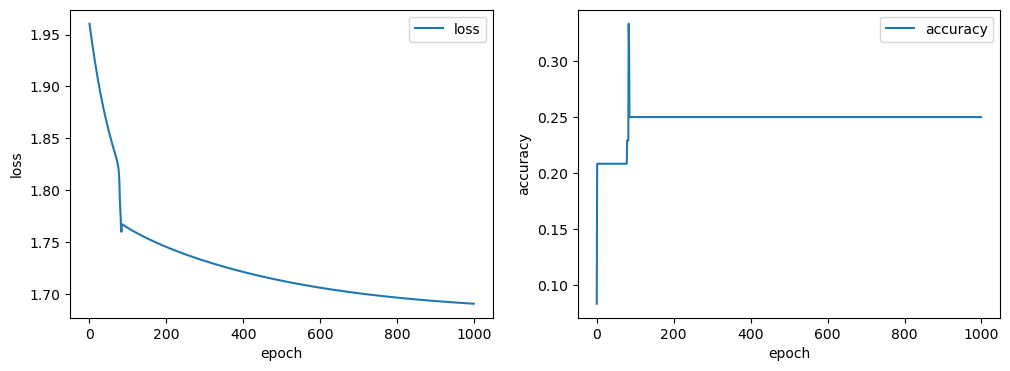

In [147]:
history1 = memory_model1.fit(train_ds, epochs=1000, verbose=0, callbacks=[TqdmCallback()])
utils.plot_history(history1, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));

1/1 [==============================] - 1s 866ms/step


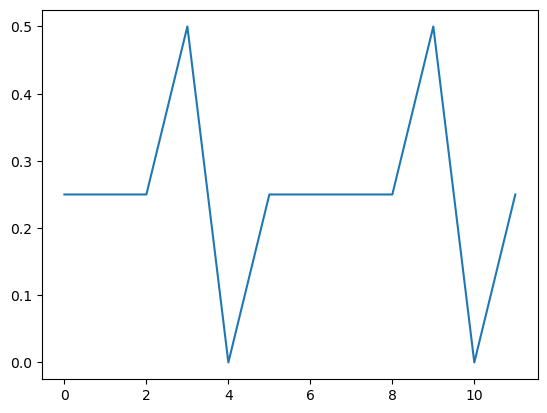

In [148]:
memory_model1.evaluate(train_ds)
memory_model1.evaluate(test_ds)

# plot accuracy as a function of position in sequence
preds1 = memory_model1.predict(train_ds)
preds1 = np.argmax(preds1, axis=-1)
acc_by_pos1 = np.mean(preds1 == train_seqs_y, axis=0)
plt.plot(acc_by_pos1)

## Kernel Model 2, use mem_seq_y as value in cross attention (only embedding, no self-attention on mem_seq_y)

In [149]:
from tensorflow.keras import layers
from transformer_modules import AddPositionalEmbedding, MemoryAddPositionalEmbedding
from attention import GlobalSelfAttention, CausalSelfAttention, CrossAttention

class KernelMemoryTransformer_cross_y(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, ff_sizes, **kwargs):
        super().__init__(**kwargs)

        self.alpha_it = None
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')

        # different self-attention layers for input and memories for encoding sequences
        self.input_self_attention = CausalSelfAttention(num_heads=n_heads, key_dim=key_dim, value_dim=embedding_dim//n_heads, name='self_attn')
        self.memory_self_attention_layer = GlobalSelfAttention(num_heads=n_heads, key_dim=key_dim, value_dim=embedding_dim//n_heads, name='mem_self_attn')

        # create cross attention layer
        self.cross_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, value_dim=embedding_dim//n_heads, name='cross_attn')

        self.feedforward = tf.keras.Sequential([layers.Dense(z, activation='relu') for z in ff_sizes], name='feedforward')
        self.output_dense = layers.Dense(vocab_size, activation='softmax', name='output')

    def memory_self_attention(self, mem_seqs):
        '''apply self-attention to each memory sequence'''
        lambda_fn = lambda x: self.memory_self_attention_layer(x)
        return tf.map_fn(lambda_fn, mem_seqs)

    def get_cross_probs(self, embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs):
        '''compute cross attention probabilities prob(x_{i+1} = . | x_{1:i}, x^{(t)}) for each memory'''

        def get_memory_cross_probs(E_xt, E_yt):
            cross_attention_output = self.cross_attention_layer(
                query=embedded_input_seqs,
                key=E_xt,
                value=E_yt)
            return cross_attention_output # shape: (batch_size, seq_len, mem_len)
        
        #print(get_memory_cross_probs(embedded_mem_x_seqs[:,0,:,:], embedded_mem_y_seqs[:,0,:,:]))
        #compute cross-attention for each memory
        cross_probs = tf.map_fn(lambda xy: get_memory_cross_probs(xy[0], xy[1]), (tf.transpose(embedded_mem_x_seqs, perm=[1, 0, 2, 3]), tf.transpose(embedded_mem_y_seqs, perm=[1, 0, 2, 3])), dtype=tf.float32)
        cross_probs = tf.transpose(cross_probs, perm=[1, 0, 2, 3]) # shape: (batch_size, n_mem, mem_length, embedding_dim)

        # compute cross-probs from cross-attention via feedforward network
        cross_probs = self.feedforward(cross_probs)
        cross_probs = self.output_dense(cross_probs) # shape: (batch_size, n_mems, mem_length, vocab_size)

        return cross_probs

    def get_observed_cross_probs(self, cross_probs, seq_input):
        '''given the cross_probs tensor, extract the components coresponding to the observed sequence'''

        cross_probs_observed = tf.transpose(cross_probs, perm=(1,0,2,3))
        cross_probs_observed = tf.map_fn(lambda x: tf.gather(x, indices=seq_input, axis=-1, batch_dims=2), cross_probs_observed)
        cross_probs_observed = tf.transpose(cross_probs_observed, perm=(1,0,2))
        return cross_probs_observed

    def compute_mem_attention_scores(self, cross_probs_observed):
        '''compute memory-level attention scores, alpha_it (i is position in input sequence, t is memory index)'''

        log_cross_probs_observed = tf.math.log(cross_probs_observed)
        w_it = tf.math.cumsum(log_cross_probs_observed, axis=-1, exclusive=True)
        alpha_it = tf.nn.softmax(w_it, axis=1) # shape [batch_size, num_mems, in_seq_length]
        return alpha_it

    def call(self, inputs):
        seq_input, memory_input_x, memory_input_y = inputs

        # embed input sequences and memory sequences
        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_input_x)
        embedded_mem_y_seqs = self.embedder(memory_input_y)

        # add positional embeddings
        embedded_input_seqs = self.pos_embedder_adder(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)
        embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)

        # encode via self-attention
        embedded_input_seqs = self.input_self_attention(embedded_input_seqs) # shape: (batch_size, input_length, embedding_dim)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs) # shape: (batch_size, num_memories, memory_length, embedding_dim)

        # compute prob(x_{i+1} = . | x_{1:i}, x^{(t)}) for each memory
        cross_probs = self.get_cross_probs(embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs)

        # compute prob(x_{i+1} | x_{1:i}, x^{(t)}) for each memory
        cross_probs_observed = self.get_observed_cross_probs(cross_probs, seq_input)

        # compute alpha_it = softmax(w_it) where w_it = sum_{j=1}^{i-1} log prob(x_{j+1} | x_{1:j}, x^{(t)})
        alpha_it = self.compute_mem_attention_scores(cross_probs_observed)
        self.alpha_it = alpha_it
        
        # compute prob(x_{i+1} | x_{1:i}, {x^{(t)}}_t) = \sum_t alpha_it * prob(x_{i+1} = . | x_{1:i}, x^{(t)})
        output = tf.reduce_sum(tf.multiply(tf.expand_dims(alpha_it, axis=-1), cross_probs), axis=1)

        return output


In [150]:
train_ds = tf.data.Dataset.from_tensor_slices(((train_seqs_x, mem_seqs_x, mem_seqs_y), train_seqs_y)).batch(4)
test_ds = tf.data.Dataset.from_tensor_slices(((test_seqs_x, mem_seqs_x, mem_seqs_y), test_seqs_y)).batch(4)

memory_model2 = KernelMemoryTransformer_cross_y(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//n_heads, n_heads=n_heads, ff_sizes = [vocab_size//2,], name='kernel_memory_model_cross_y')

memory_model2([train_seqs_x[:64], mem_seqs_x[:64], mem_seqs_y[:64]]); # build model
create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
memory_model2.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model2.summary()

Model: "kernel_memory_model_cross_y"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  12        
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 causal_self_attention_16 (C  multiple                 28        
 ausalSelfAttention)                                             
                                                                 
 global_self_attention_16 (G  multiple                 28        
 lobalSelfAttention)                   

100%|██████████| 1000/1000 [00:34<00:00, 28.91epoch/s, loss=1.27, accuracy=0.542]


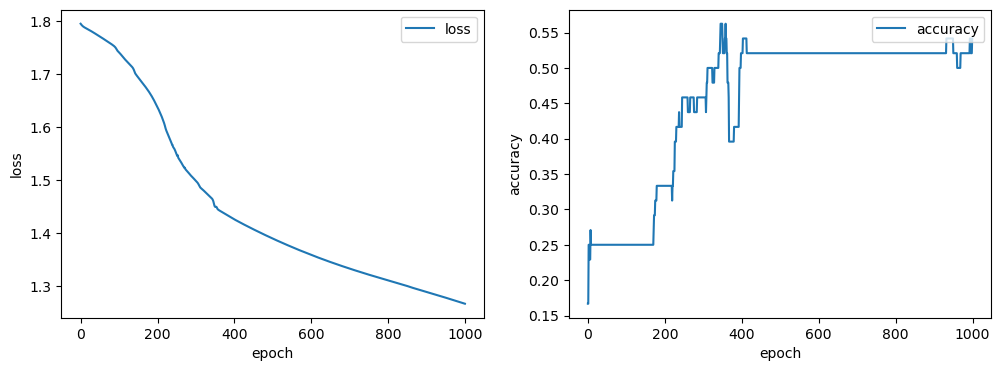

In [151]:
history2 = memory_model2.fit(train_ds, epochs=1000, verbose=0, callbacks=[TqdmCallback()])
utils.plot_history(history2, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));

1/1 [==============================] - 1s 895ms/step


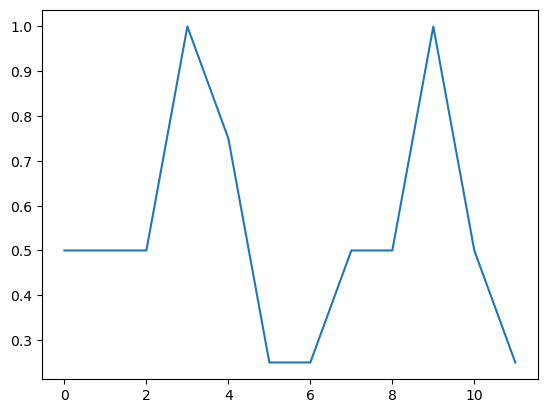

In [152]:
memory_model2.evaluate(train_ds)
memory_model2.evaluate(test_ds)

# plot accuracy as a function of position in sequence
preds2 = memory_model2.predict(train_ds)
preds2 = np.argmax(preds2, axis=-1)
acc_by_pos2 = np.mean(preds2 == train_seqs_y, axis=0)
plt.plot(acc_by_pos2)

## Attention Visualization

In [153]:
from utils_kernel_transformer import plot_seq_attention

def plot_attention2(sample_input_index, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model):
    """
    choose sample input and plot the attention associated to the argmax probability vocab at each input position 
    (memory_seq versus each input element), call plot_seq_attention as subfunction
    """
    b = sample_input_index
    sample_input = seqs_x_train[b:b+1]
    print("sample_input: ",sample_input)
    sample_mem_seq_x = mem_seqs_x_train[b:b+1]
    sample_mem_seq_y = mem_seqs_y_train[b:b+1]

    pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
    pred = np.argmax(pred, axis=-1)
    print(f'prediction: {pred[0]}')
    print(f'y: {seqs_y_train[b]}')
    print(pred[0] == seqs_y_train[b])
    attn_ = memory_model.alpha_it[0]
    #print(attn_output_seq.shape)
    plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])


sample_input:  [[1 3 5 3 5 3 1 3 5 3 5 3]]
prediction: [2 2 2 2 2 2 2 2 2 2 2 2]
y: [3 5 3 5 3 1 3 5 3 5 3 1]
[False False False False False False False False False False False False]
sample_input:  [[5 0 1 0 5 0 5 0 1 0 5 0]]
prediction: [2 2 2 2 2 2 2 2 2 2 2 2]
y: [0 1 0 5 0 5 0 1 0 5 0 5]
[False False False False False False False False False False False False]
sample_input:  [[3 2 1 2 2 5 3 2 1 2 2 5]]
prediction: [2 2 2 2 2 2 2 2 2 2 2 2]
y: [2 1 2 2 5 3 2 1 2 2 5 3]
[ True False  True  True False False  True False  True  True False False]
sample_input:  [[2 0 2 4 2 5 2 0 2 4 2 5]]
prediction: [2 2 2 2 2 2 2 2 2 2 2 2]
y: [0 2 4 2 5 2 0 2 4 2 5 2]
[False  True False  True False  True False  True False  True False  True]


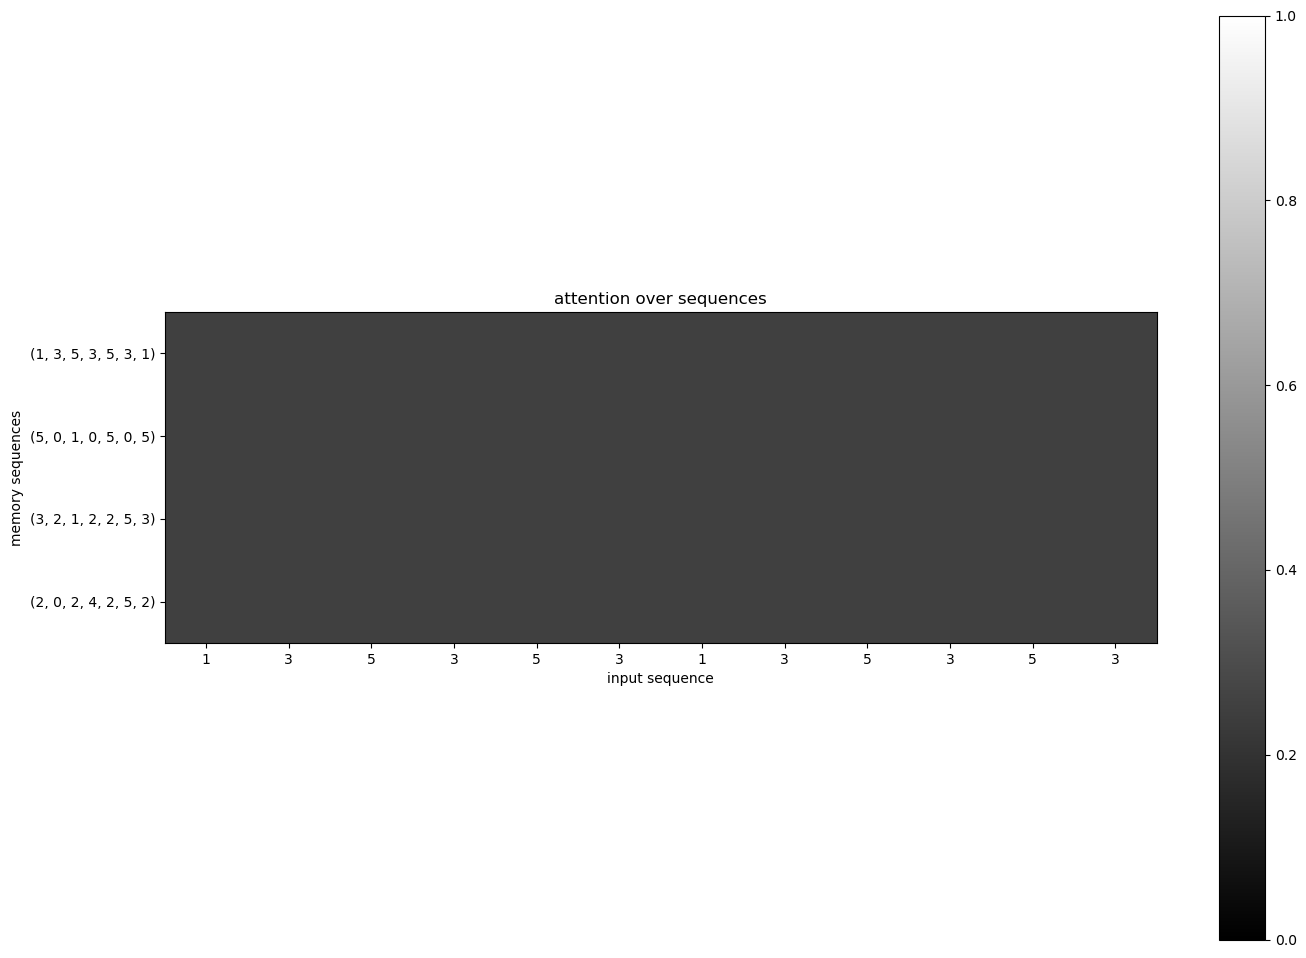

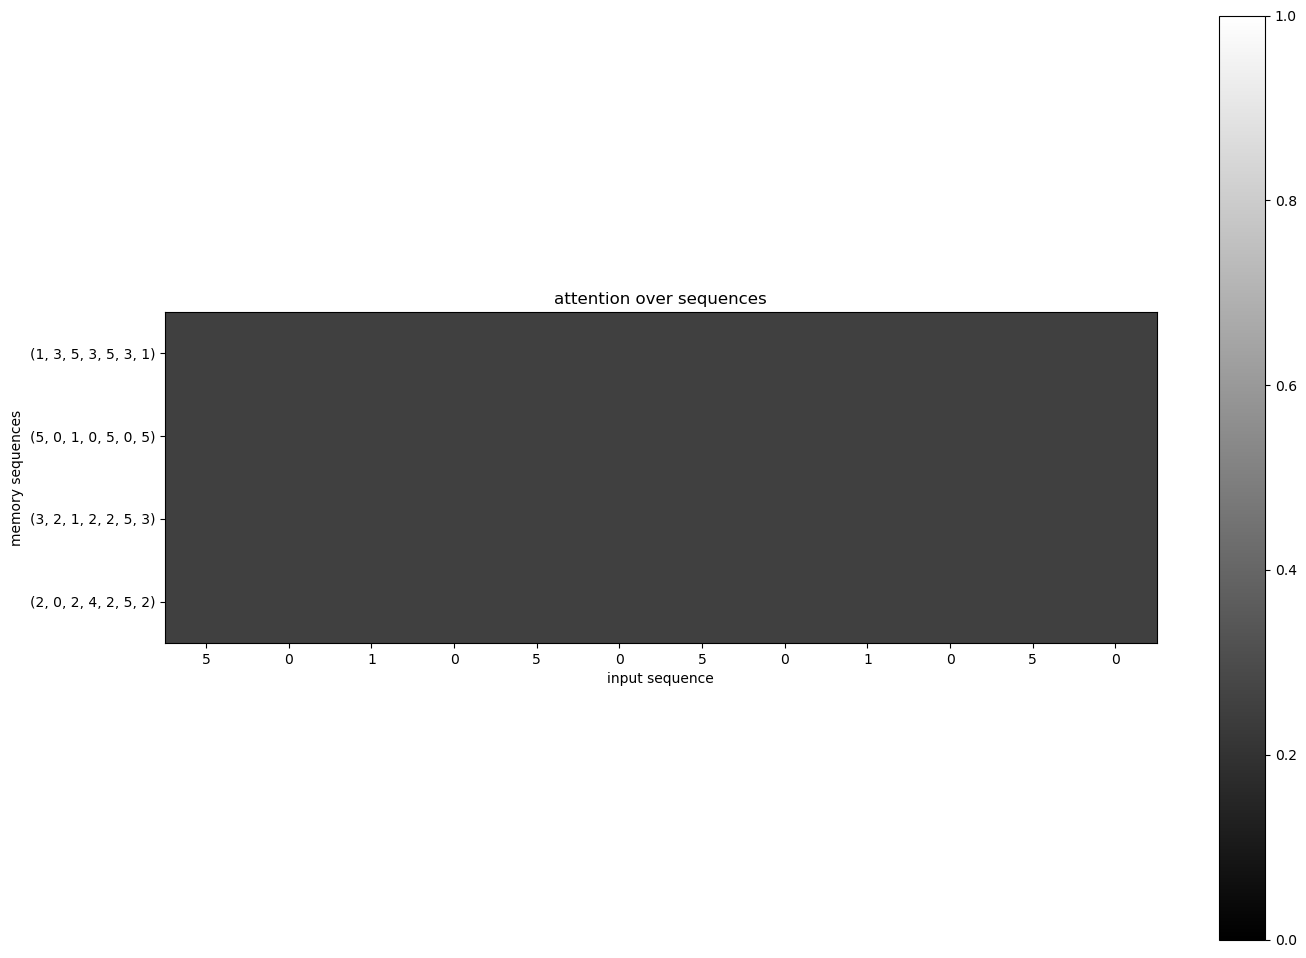

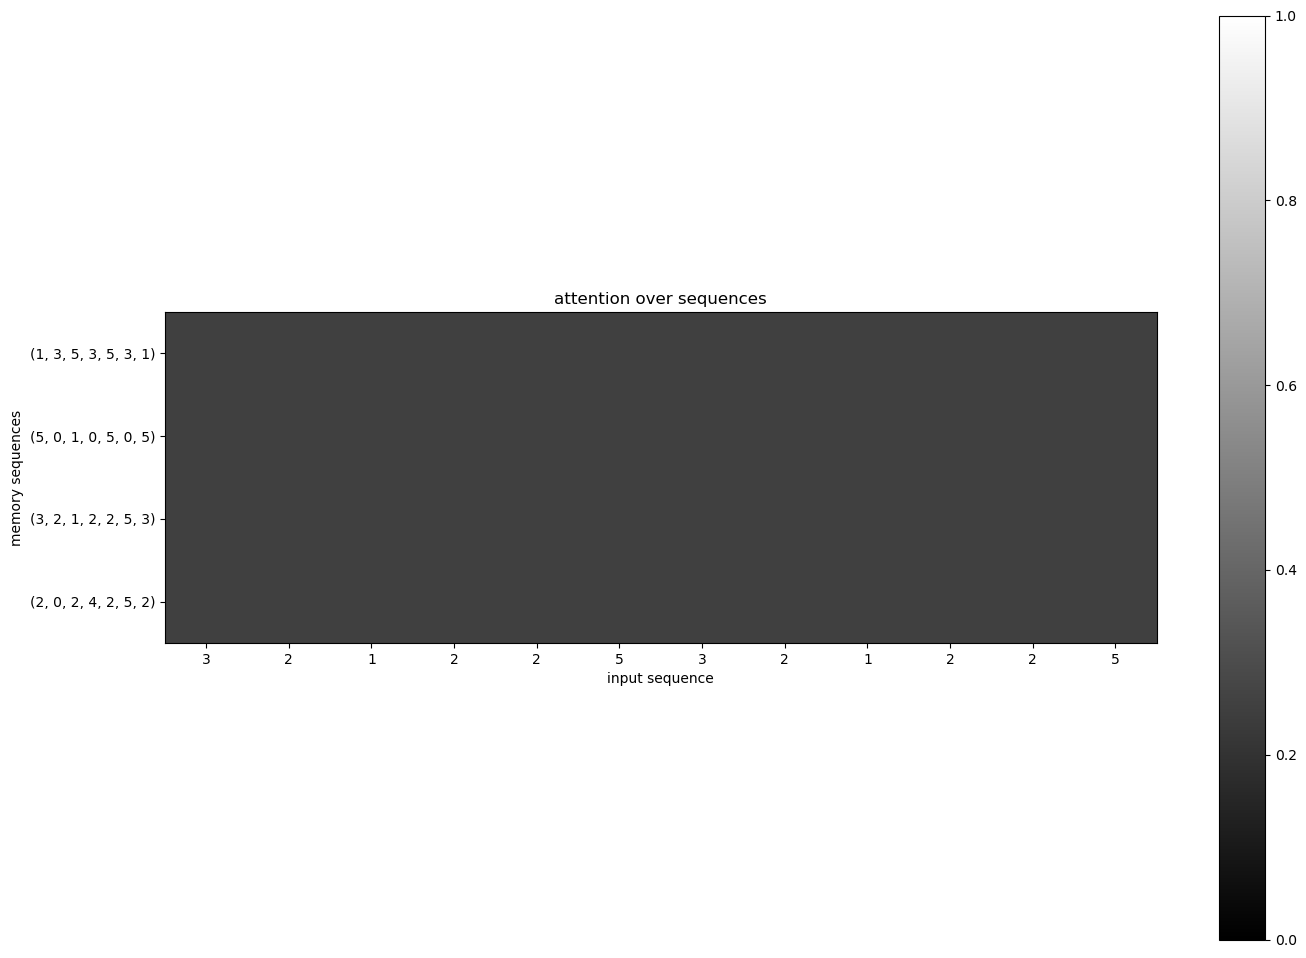

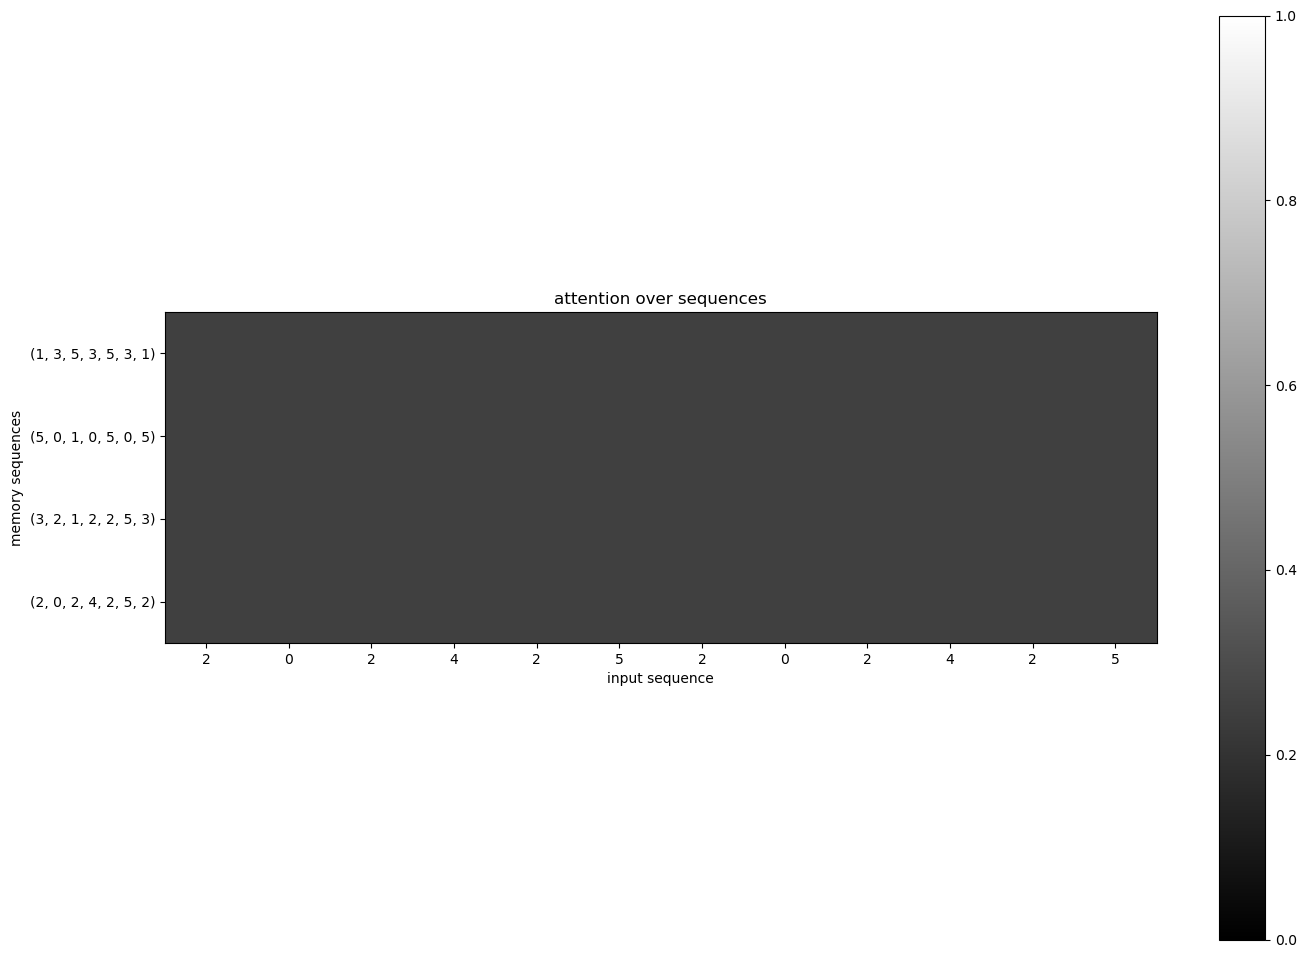

In [156]:
from utils_kernel_transformer import plot_attention as plot_attention1

import numpy as np
import matplotlib.pyplot as plt

for idx in range(4):
    plot_attention1(idx, train_seqs_x, train_seqs_y, mem_seqs_x, mem_seqs_y, memory_model1)

sample_input:  [[1 3 5 3 5 3 1 3 5 3 5 3]]
prediction: [0 5 2 5 5 5 5 5 2 5 3 5]
y: [3 5 3 5 3 1 3 5 3 5 3 1]
[False  True False  True False False False  True False  True  True False]
sample_input:  [[5 0 1 0 5 0 5 0 1 0 5 0]]
prediction: [0 5 0 5 0 0 0 5 0 5 0 0]
y: [0 1 0 5 0 5 0 1 0 5 0 5]
[ True False  True  True  True False  True False  True  True  True False]
sample_input:  [[3 2 1 2 2 5 3 2 1 2 2 5]]
prediction: [0 5 2 2 5 3 3 3 2 2 3 3]
y: [2 1 2 2 5 3 2 1 2 2 5 3]
[False False  True  True  True  True False False  True  True False  True]
sample_input:  [[2 0 2 4 2 5 2 0 2 4 2 5]]
prediction: [0 2 2 2 5 3 3 2 2 2 3 3]
y: [0 2 4 2 5 2 0 2 4 2 5 2]
[ True  True False  True  True False False  True False  True False False]


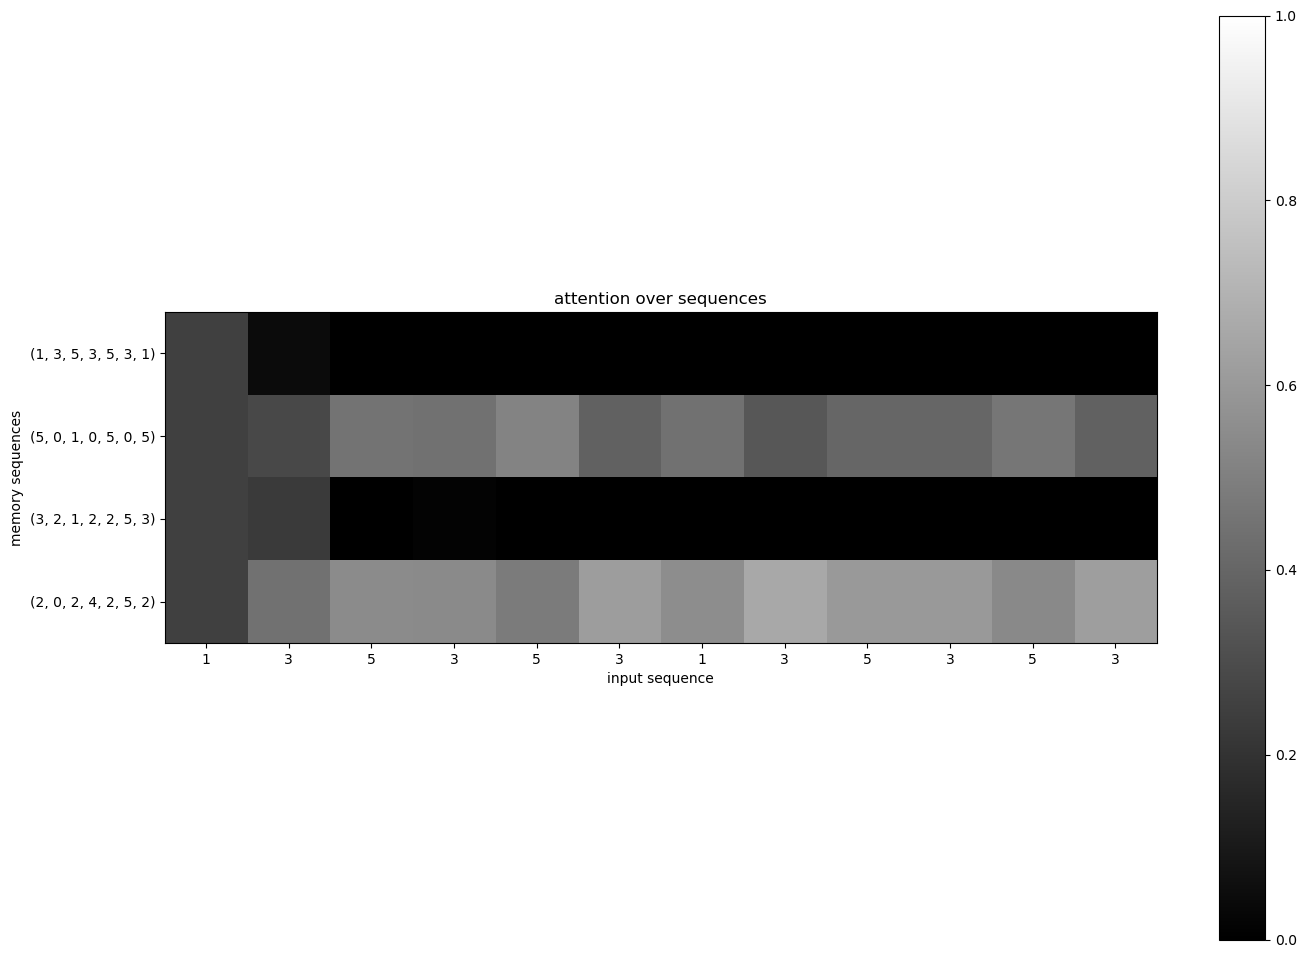

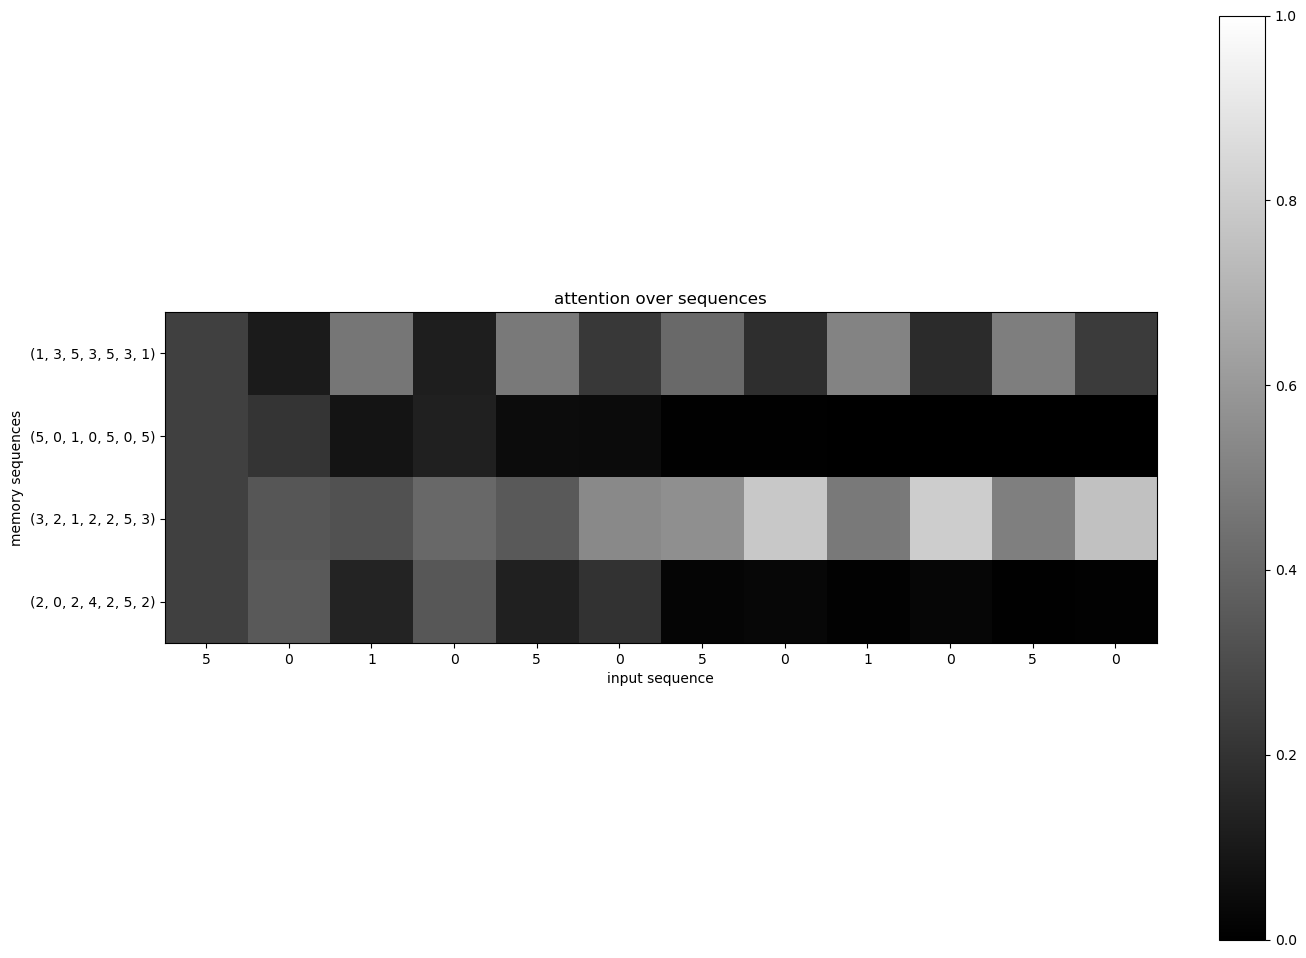

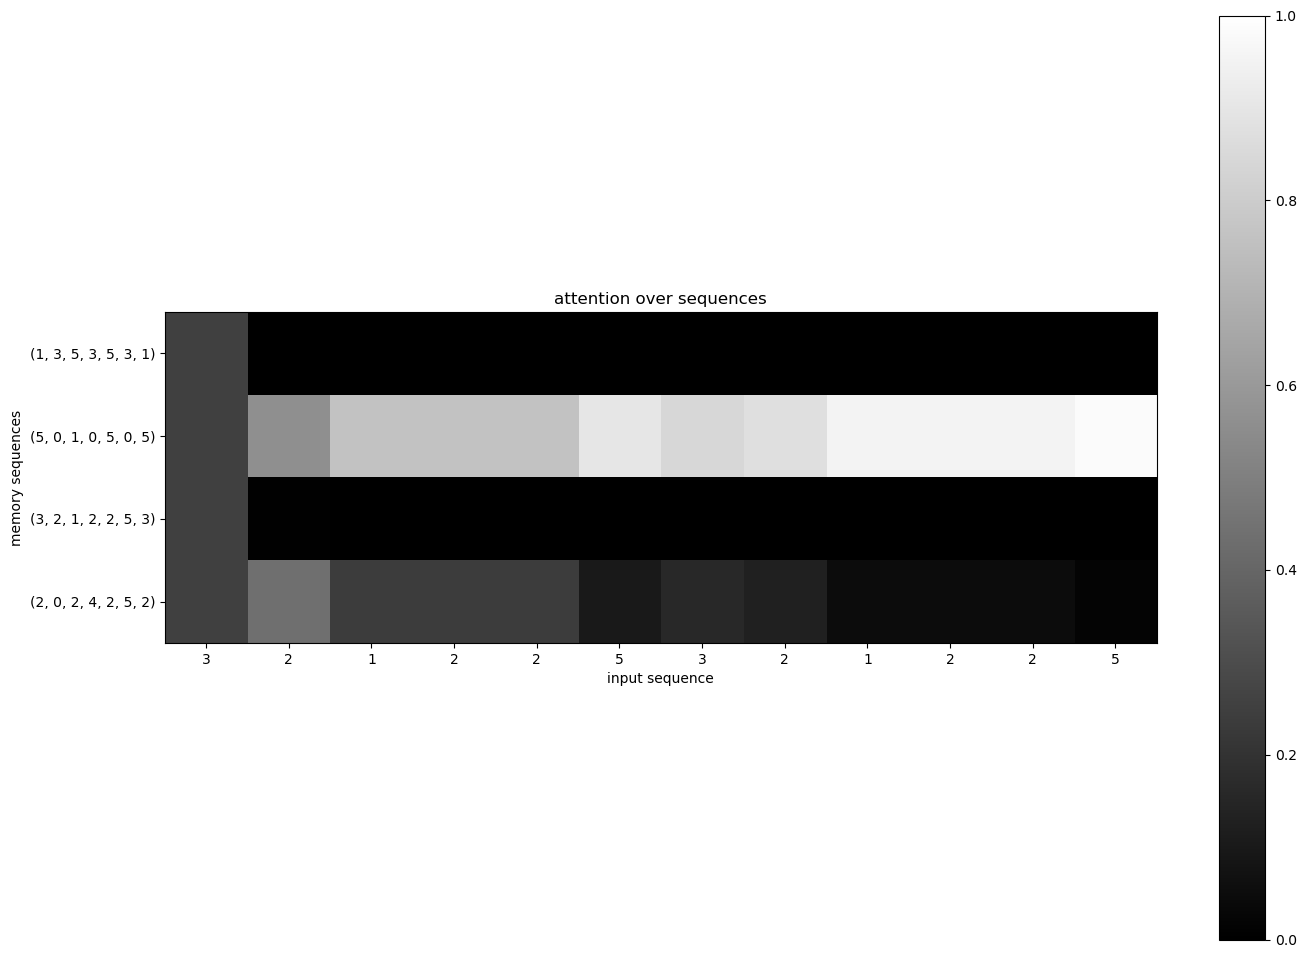

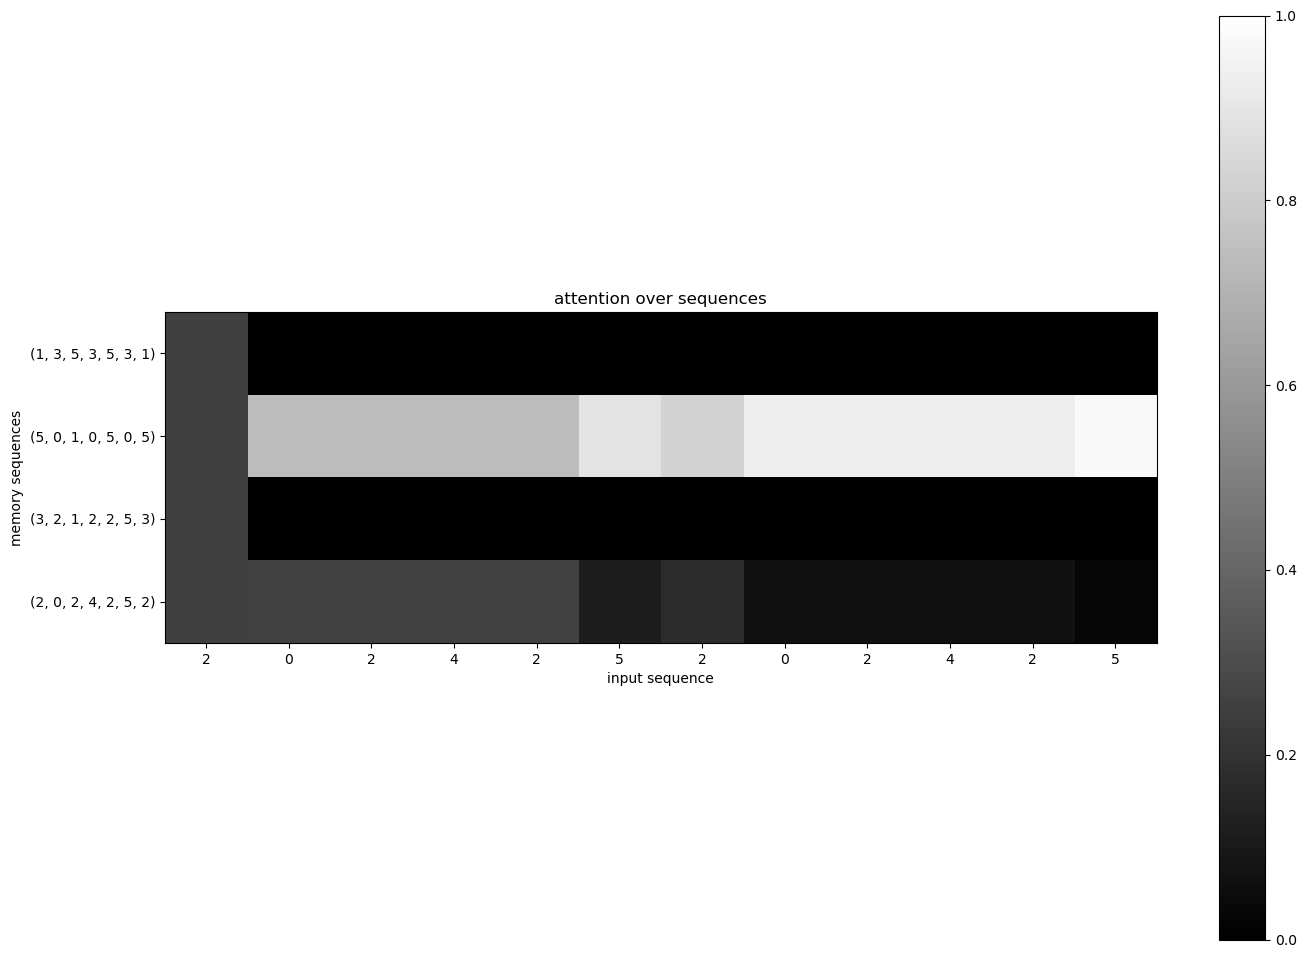

In [158]:
for idx in range(4):
    plot_attention2(idx, train_seqs_x, train_seqs_y, mem_seqs_x, mem_seqs_y, memory_model2)

# A more complicated setting

In [184]:
num_loops = 16
loop_length = 8 # for now, fixed length
num_notes = 8 # size of observation space

state_transition_edges = []

for l in range(num_loops):
    for s in range(loop_length):
        state_transition_edges.append((f's{l}{s}', f's{l}{(s+1)%loop_length}'))

    # NOTE: this adds connections between loops
    # for l2 in range(num_loops):
    #     state_transition_edges.append((f's{l}0', f's{l2}0'))

In [185]:
graph = nx.DiGraph(state_transition_edges)
states = list(graph.nodes())
state_to_idx = {s: i for i, s in enumerate(states)}
idx_to_state = {i: s for i, s in enumerate(states)}

emissions = [f'o{i}' for i in range(num_notes)]
idx_to_emission = {i: o for i,o in enumerate(emissions)}
emission_to_idx = {o: i for i,o in enumerate(emissions)}

In [186]:
state_transition_matrix = np.array(nx.adjacency_matrix(graph, nodelist=state_to_idx.keys()).todense())
state_transition_matrix = state_transition_matrix / np.sum(state_transition_matrix, axis=0)[:, np.newaxis]

/var/folders/86/rz4f689d2sb1ld1x196j98zm0000gn/T/ipykernel_1198/216198539.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  state_transition_matrix = np.array(nx.adjacency_matrix(graph, nodelist=state_to_idx.keys()).todense())


In [187]:
emissions_dict = {s: idx_to_emission[np.random.randint(num_notes)] for s in states}
emissions_dict

{'s00': 'o2',
 's01': 'o7',
 's02': 'o5',
 's03': 'o3',
 's04': 'o1',
 's05': 'o2',
 's06': 'o0',
 's07': 'o5',
 's10': 'o6',
 's11': 'o3',
 's12': 'o5',
 's13': 'o7',
 's14': 'o3',
 's15': 'o5',
 's16': 'o1',
 's17': 'o1',
 's20': 'o6',
 's21': 'o6',
 's22': 'o6',
 's23': 'o1',
 's24': 'o6',
 's25': 'o1',
 's26': 'o6',
 's27': 'o4',
 's30': 'o5',
 's31': 'o7',
 's32': 'o7',
 's33': 'o5',
 's34': 'o2',
 's35': 'o0',
 's36': 'o7',
 's37': 'o7',
 's40': 'o4',
 's41': 'o0',
 's42': 'o3',
 's43': 'o2',
 's44': 'o7',
 's45': 'o7',
 's46': 'o6',
 's47': 'o1',
 's50': 'o6',
 's51': 'o7',
 's52': 'o0',
 's53': 'o1',
 's54': 'o0',
 's55': 'o5',
 's56': 'o7',
 's57': 'o3',
 's60': 'o0',
 's61': 'o0',
 's62': 'o3',
 's63': 'o2',
 's64': 'o0',
 's65': 'o6',
 's66': 'o1',
 's67': 'o5',
 's70': 'o2',
 's71': 'o0',
 's72': 'o1',
 's73': 'o7',
 's74': 'o6',
 's75': 'o2',
 's76': 'o5',
 's77': 'o4',
 's80': 'o4',
 's81': 'o1',
 's82': 'o0',
 's83': 'o7',
 's84': 'o7',
 's85': 'o4',
 's86': 'o4',
 's87'

In [188]:
emissions_matrix = np.zeros((len(states), num_notes))
for i, s in enumerate(states):
    emissions_matrix[i, emission_to_idx[emissions_dict[s]]] = 1

In [189]:
mem_seq_len = loop_length + 1
input_seq_len = 2*loop_length

mem_seq_initial_states = [f's{l}0' for l in range(num_loops)]
input_seqs_initial_states = [f's{l}0' for l in range(num_loops)]

train_seqs = np.array([sample_hmm(state_transition_matrix, emissions_matrix, initial_state, input_seq_len+1) for initial_state in input_seqs_initial_states])
train_state_seqs, train_emissions_seqs = train_seqs[:, 0, :], train_seqs[:, 1, :]
train_seqs_x = train_emissions_seqs[:, :-1]
train_seqs_y = train_emissions_seqs[:, 1:]

test_seqs = np.array([sample_hmm(state_transition_matrix, emissions_matrix, initial_state, input_seq_len+1) for initial_state in input_seqs_initial_states])
test_state_seqs, test_emissions_seqs = test_seqs[:, 0, :], test_seqs[:, 1, :]
test_seqs_x = test_emissions_seqs[:, :-1]
test_seqs_y = test_emissions_seqs[:, 1:]


mem_seqs = np.array([sample_hmm(state_transition_matrix, emissions_matrix, initial_state, mem_seq_len + 1) for initial_state in mem_seq_initial_states])
mem_seqs = np.repeat(np.expand_dims(mem_seqs, axis=0), axis=0, repeats=len(train_seqs))
mem_state_seqs, mem_emissions_seqs = mem_seqs[:, :, 0, :], mem_seqs[:, :, 1, :]
mem_seqs_x = mem_emissions_seqs[:, :, :-1]
mem_seqs_y = mem_emissions_seqs[:, :, 1:]


In [190]:
print(f'train_seqs_x.shape: {train_seqs_x.shape}; train_seqs_y.shape: {train_seqs_y.shape}') # shape [batch_size, seq_len]
print(f'mem_seqs_x.shape: {mem_seqs_x.shape}; mem_seqs_y.shape: {mem_seqs_y.shape}') # shape [batch_size, num_mem_seqs, mem_seq_len]

train_seqs_x.shape: (16, 16); train_seqs_y.shape: (16, 16)
mem_seqs_x.shape: (16, 16, 9); mem_seqs_y.shape: (16, 16, 9)


In [191]:
mem_state_seqs[0]

array([['s00', 's01', 's02', 's03', 's04', 's05', 's06', 's07', 's00',
        's01'],
       ['s10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's10',
        's11'],
       ['s20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's20',
        's21'],
       ['s30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's30',
        's31'],
       ['s40', 's41', 's42', 's43', 's44', 's45', 's46', 's47', 's40',
        's41'],
       ['s50', 's51', 's52', 's53', 's54', 's55', 's56', 's57', 's50',
        's51'],
       ['s60', 's61', 's62', 's63', 's64', 's65', 's66', 's67', 's60',
        's61'],
       ['s70', 's71', 's72', 's73', 's74', 's75', 's76', 's77', 's70',
        's71'],
       ['s80', 's81', 's82', 's83', 's84', 's85', 's86', 's87', 's80',
        's81'],
       ['s90', 's91', 's92', 's93', 's94', 's95', 's96', 's97', 's90',
        's91'],
       ['s100', 's101', 's102', 's103', 's104', 's105', 's106', 's107',
        's100', 's101'],
       ['s110', 's111', 's112', '

In [192]:
mem_seqs_x[0]

array([['o2', 'o7', 'o5', 'o3', 'o1', 'o2', 'o0', 'o5', 'o2'],
       ['o6', 'o3', 'o5', 'o7', 'o3', 'o5', 'o1', 'o1', 'o6'],
       ['o6', 'o6', 'o6', 'o1', 'o6', 'o1', 'o6', 'o4', 'o6'],
       ['o5', 'o7', 'o7', 'o5', 'o2', 'o0', 'o7', 'o7', 'o5'],
       ['o4', 'o0', 'o3', 'o2', 'o7', 'o7', 'o6', 'o1', 'o4'],
       ['o6', 'o7', 'o0', 'o1', 'o0', 'o5', 'o7', 'o3', 'o6'],
       ['o0', 'o0', 'o3', 'o2', 'o0', 'o6', 'o1', 'o5', 'o0'],
       ['o2', 'o0', 'o1', 'o7', 'o6', 'o2', 'o5', 'o4', 'o2'],
       ['o4', 'o1', 'o0', 'o7', 'o7', 'o4', 'o4', 'o6', 'o4'],
       ['o0', 'o5', 'o4', 'o7', 'o2', 'o2', 'o5', 'o2', 'o0'],
       ['o2', 'o2', 'o7', 'o5', 'o7', 'o0', 'o1', 'o1', 'o2'],
       ['o4', 'o7', 'o0', 'o2', 'o6', 'o7', 'o3', 'o6', 'o4'],
       ['o6', 'o3', 'o6', 'o7', 'o4', 'o3', 'o3', 'o6', 'o6'],
       ['o0', 'o2', 'o3', 'o3', 'o1', 'o1', 'o4', 'o1', 'o0'],
       ['o0', 'o0', 'o0', 'o1', 'o2', 'o7', 'o4', 'o5', 'o0'],
       ['o4', 'o7', 'o2', 'o7', 'o6', 'o3', 'o2', 'o0',

In [193]:
train_seqs_x

array([['o2', 'o7', 'o5', 'o3', 'o1', 'o2', 'o0', 'o5', 'o2', 'o7', 'o5',
        'o3', 'o1', 'o2', 'o0', 'o5'],
       ['o6', 'o3', 'o5', 'o7', 'o3', 'o5', 'o1', 'o1', 'o6', 'o3', 'o5',
        'o7', 'o3', 'o5', 'o1', 'o1'],
       ['o6', 'o6', 'o6', 'o1', 'o6', 'o1', 'o6', 'o4', 'o6', 'o6', 'o6',
        'o1', 'o6', 'o1', 'o6', 'o4'],
       ['o5', 'o7', 'o7', 'o5', 'o2', 'o0', 'o7', 'o7', 'o5', 'o7', 'o7',
        'o5', 'o2', 'o0', 'o7', 'o7'],
       ['o4', 'o0', 'o3', 'o2', 'o7', 'o7', 'o6', 'o1', 'o4', 'o0', 'o3',
        'o2', 'o7', 'o7', 'o6', 'o1'],
       ['o6', 'o7', 'o0', 'o1', 'o0', 'o5', 'o7', 'o3', 'o6', 'o7', 'o0',
        'o1', 'o0', 'o5', 'o7', 'o3'],
       ['o0', 'o0', 'o3', 'o2', 'o0', 'o6', 'o1', 'o5', 'o0', 'o0', 'o3',
        'o2', 'o0', 'o6', 'o1', 'o5'],
       ['o2', 'o0', 'o1', 'o7', 'o6', 'o2', 'o5', 'o4', 'o2', 'o0', 'o1',
        'o7', 'o6', 'o2', 'o5', 'o4'],
       ['o4', 'o1', 'o0', 'o7', 'o7', 'o4', 'o4', 'o6', 'o4', 'o1', 'o0',
        'o7', 'o7', 'o

In [194]:
maptoidx = np.vectorize(lambda x: emission_to_idx[x])
train_seqs_x = maptoidx(train_seqs_x)
train_seqs_y = maptoidx(train_seqs_y)
test_seqs_x = maptoidx(test_seqs_x)
test_seqs_y = maptoidx(test_seqs_y)
mem_seqs_x = maptoidx(mem_seqs_x)
mem_seqs_y = maptoidx(mem_seqs_y)

In [195]:
mem_seqs_x

array([[[2, 7, 5, ..., 0, 5, 2],
        [6, 3, 5, ..., 1, 1, 6],
        [6, 6, 6, ..., 6, 4, 6],
        ...,
        [0, 2, 3, ..., 4, 1, 0],
        [0, 0, 0, ..., 4, 5, 0],
        [4, 7, 2, ..., 2, 0, 4]],

       [[2, 7, 5, ..., 0, 5, 2],
        [6, 3, 5, ..., 1, 1, 6],
        [6, 6, 6, ..., 6, 4, 6],
        ...,
        [0, 2, 3, ..., 4, 1, 0],
        [0, 0, 0, ..., 4, 5, 0],
        [4, 7, 2, ..., 2, 0, 4]],

       [[2, 7, 5, ..., 0, 5, 2],
        [6, 3, 5, ..., 1, 1, 6],
        [6, 6, 6, ..., 6, 4, 6],
        ...,
        [0, 2, 3, ..., 4, 1, 0],
        [0, 0, 0, ..., 4, 5, 0],
        [4, 7, 2, ..., 2, 0, 4]],

       ...,

       [[2, 7, 5, ..., 0, 5, 2],
        [6, 3, 5, ..., 1, 1, 6],
        [6, 6, 6, ..., 6, 4, 6],
        ...,
        [0, 2, 3, ..., 4, 1, 0],
        [0, 0, 0, ..., 4, 5, 0],
        [4, 7, 2, ..., 2, 0, 4]],

       [[2, 7, 5, ..., 0, 5, 2],
        [6, 3, 5, ..., 1, 1, 6],
        [6, 6, 6, ..., 6, 4, 6],
        ...,
        [0, 2, 3, ..., 

In [196]:
train_seqs_x
test_seqs_x

array([[2, 7, 5, 3, 1, 2, 0, 5, 2, 7, 5, 3, 1, 2, 0, 5],
       [6, 3, 5, 7, 3, 5, 1, 1, 6, 3, 5, 7, 3, 5, 1, 1],
       [6, 6, 6, 1, 6, 1, 6, 4, 6, 6, 6, 1, 6, 1, 6, 4],
       [5, 7, 7, 5, 2, 0, 7, 7, 5, 7, 7, 5, 2, 0, 7, 7],
       [4, 0, 3, 2, 7, 7, 6, 1, 4, 0, 3, 2, 7, 7, 6, 1],
       [6, 7, 0, 1, 0, 5, 7, 3, 6, 7, 0, 1, 0, 5, 7, 3],
       [0, 0, 3, 2, 0, 6, 1, 5, 0, 0, 3, 2, 0, 6, 1, 5],
       [2, 0, 1, 7, 6, 2, 5, 4, 2, 0, 1, 7, 6, 2, 5, 4],
       [4, 1, 0, 7, 7, 4, 4, 6, 4, 1, 0, 7, 7, 4, 4, 6],
       [0, 5, 4, 7, 2, 2, 5, 2, 0, 5, 4, 7, 2, 2, 5, 2],
       [2, 2, 7, 5, 7, 0, 1, 1, 2, 2, 7, 5, 7, 0, 1, 1],
       [4, 7, 0, 2, 6, 7, 3, 6, 4, 7, 0, 2, 6, 7, 3, 6],
       [6, 3, 6, 7, 4, 3, 3, 6, 6, 3, 6, 7, 4, 3, 3, 6],
       [0, 2, 3, 3, 1, 1, 4, 1, 0, 2, 3, 3, 1, 1, 4, 1],
       [0, 0, 0, 1, 2, 7, 4, 5, 0, 0, 0, 1, 2, 7, 4, 5],
       [4, 7, 2, 7, 6, 3, 2, 0, 4, 7, 2, 7, 6, 3, 2, 0]])

### Define Memory Model

In [197]:
import tensorflow as tf
from tensorflow.keras import layers

train_ds = tf.data.Dataset.from_tensor_slices(((train_seqs_x, mem_seqs_x), train_seqs_y)).batch(4)
test_ds = tf.data.Dataset.from_tensor_slices(((test_seqs_x, mem_seqs_x), test_seqs_y)).batch(4)

In [199]:
from kernel_memory_transformer import KernelMemoryTransformer
vocab_size = num_notes
embedding_dim = num_notes // 2
n_heads = 2
memory_model11 = KernelMemoryTransformer(vocab_size, 
                                        embedding_dim=embedding_dim, key_dim=embedding_dim // n_heads, 
                                        n_heads=n_heads, ff_sizes = [embedding_dim, ], name='kernel_memory_model')
memory_model11([train_seqs_x, mem_seqs_x]); # build model

create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
memory_model11.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model11.summary()

Model: "kernel_memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  32        
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 causal_self_attention_18 (C  multiple                 88        
 ausalSelfAttention)                                             
                                                                 
 global_self_attention_18 (G  multiple                 88        
 lobalSelfAttention)                           

100%|██████████| 1000/1000 [02:37<00:00,  6.36epoch/s, loss=1.45, accuracy=0.395]


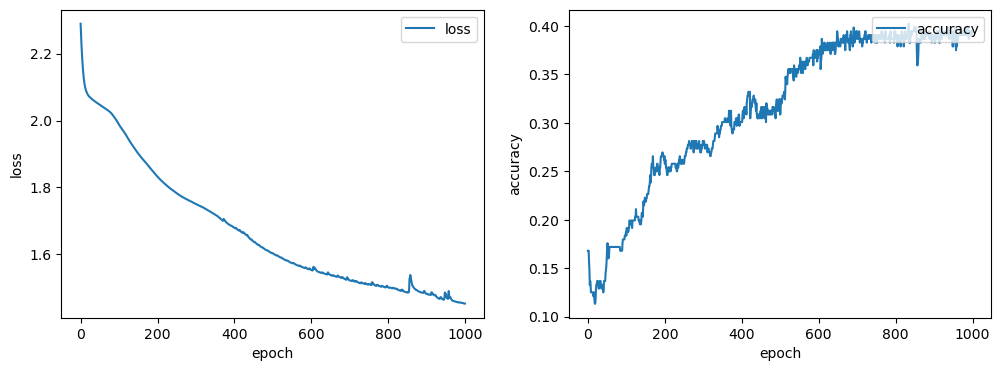

In [200]:
history11 = memory_model11.fit(train_ds, epochs=1000, verbose=0, callbacks=[TqdmCallback()])
utils.plot_history(history11, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));

4/4 [==============================] - 5s 31ms/step


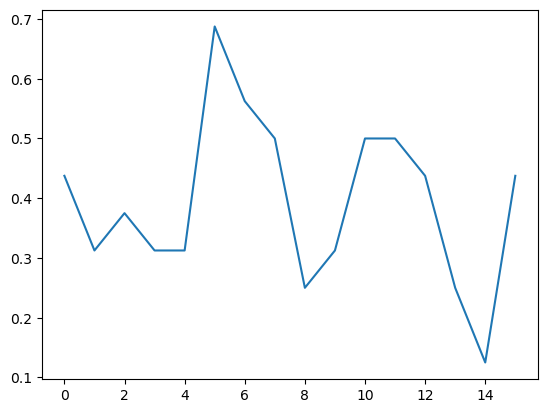

In [201]:
memory_model11.evaluate(train_ds)
memory_model11.evaluate(test_ds)

# plot accuracy as a function of position in sequence
preds11 = memory_model11.predict(train_ds)
preds11 = np.argmax(preds11, axis=-1)
acc_by_pos11 = np.mean(preds11 == train_seqs_y, axis=0)
plt.plot(acc_by_pos11)

sample_input:  [[2 7 5 3 1 2 0 5 2 7 5 3 1 2 0 5]]
prediction: [7 5 4 2 2 7 5 2 7 5 3 1 0 0 2 2]
y: [7 5 3 1 2 0 5 2 7 5 3 1 2 0 5 2]
[ True  True False False  True False  True  True  True  True  True  True
 False  True False  True]
sample_input:  [[6 3 5 7 3 5 1 1 6 3 5 7 3 5 1 1]]
prediction: [3 2 6 2 5 1 6 2 4 2 4 4 5 4 2 2]
y: [3 5 7 3 5 1 1 6 3 5 7 3 5 1 1 6]
[ True False False False  True  True False False False False False False
  True False False False]
sample_input:  [[6 6 6 1 6 1 6 4 6 6 6 1 6 1 6 4]]
prediction: [3 6 6 2 4 6 4 6 4 4 4 4 4 2 6 6]
y: [6 6 1 6 1 6 4 6 6 6 1 6 1 6 4 6]
[False  True False False False  True  True  True False False False False
 False False False  True]
sample_input:  [[5 7 7 5 2 0 7 7 5 7 7 5 2 0 7 7]]
prediction: [7 5 5 2 7 7 5 5 0 5 5 7 7 0 5 5]
y: [7 7 5 2 0 7 7 5 7 7 5 2 0 7 7 5]
[ True False  True  True False  True False  True False False  True False
 False False False  True]


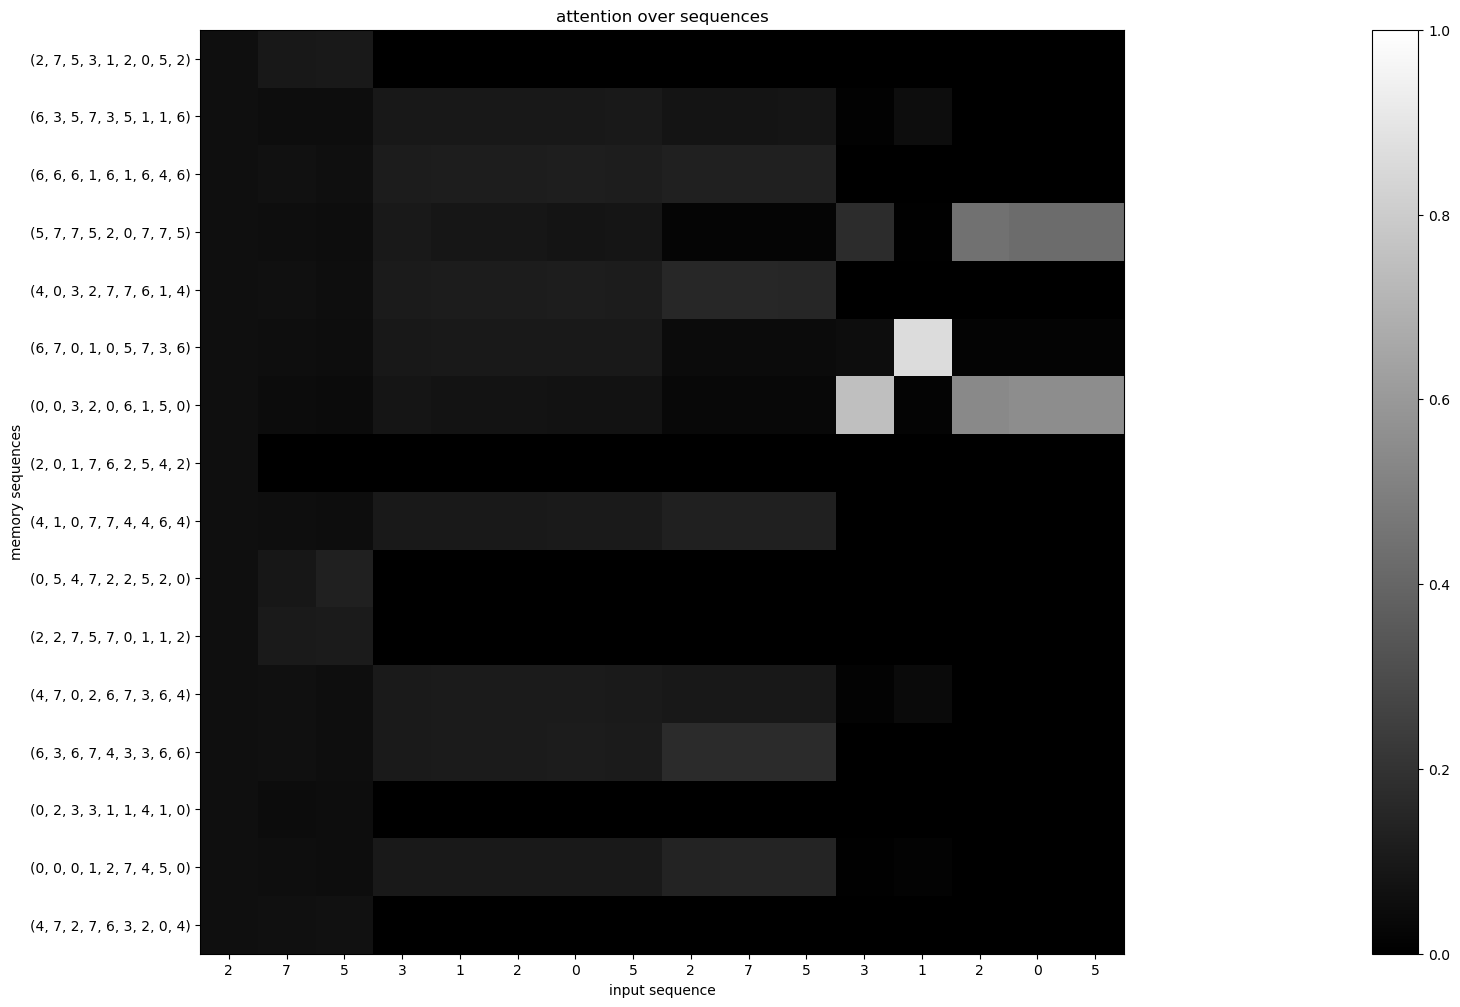

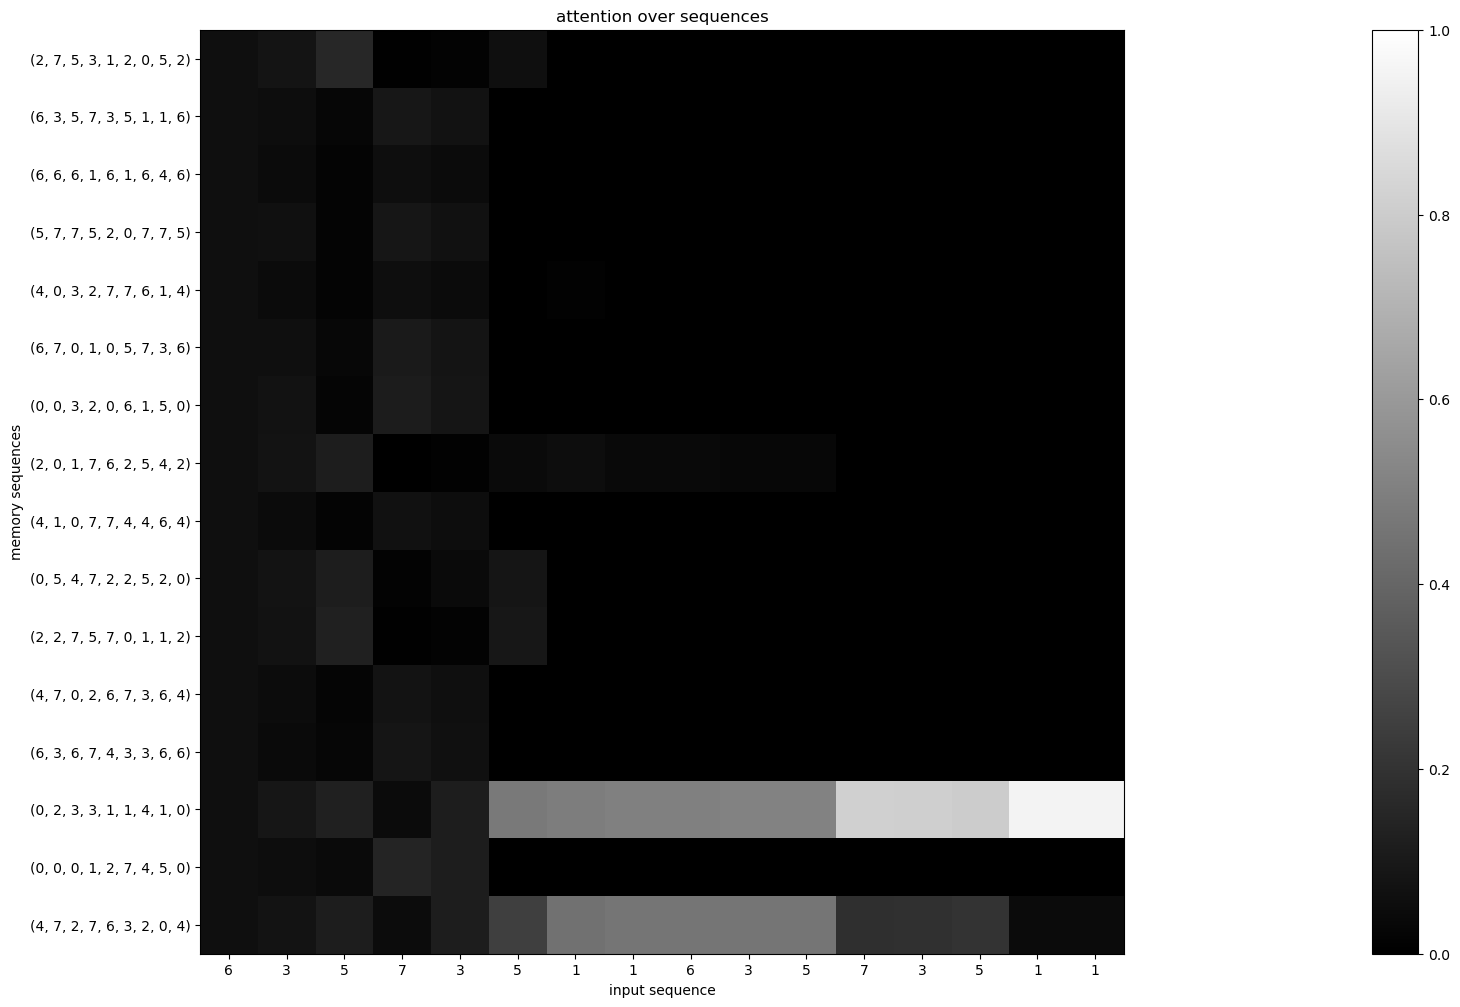

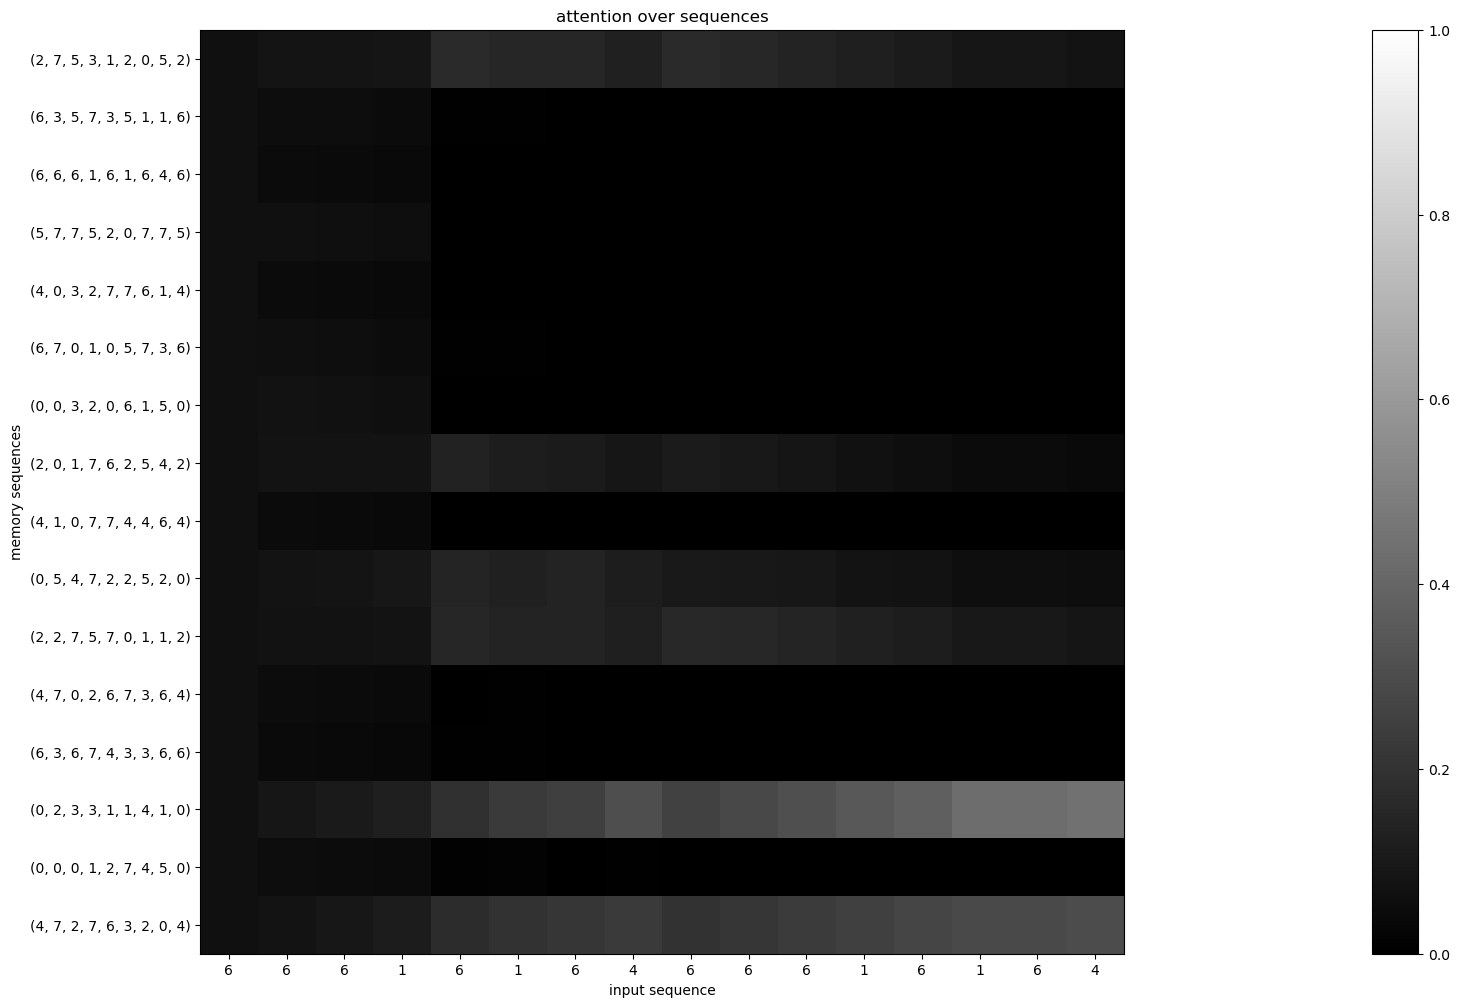

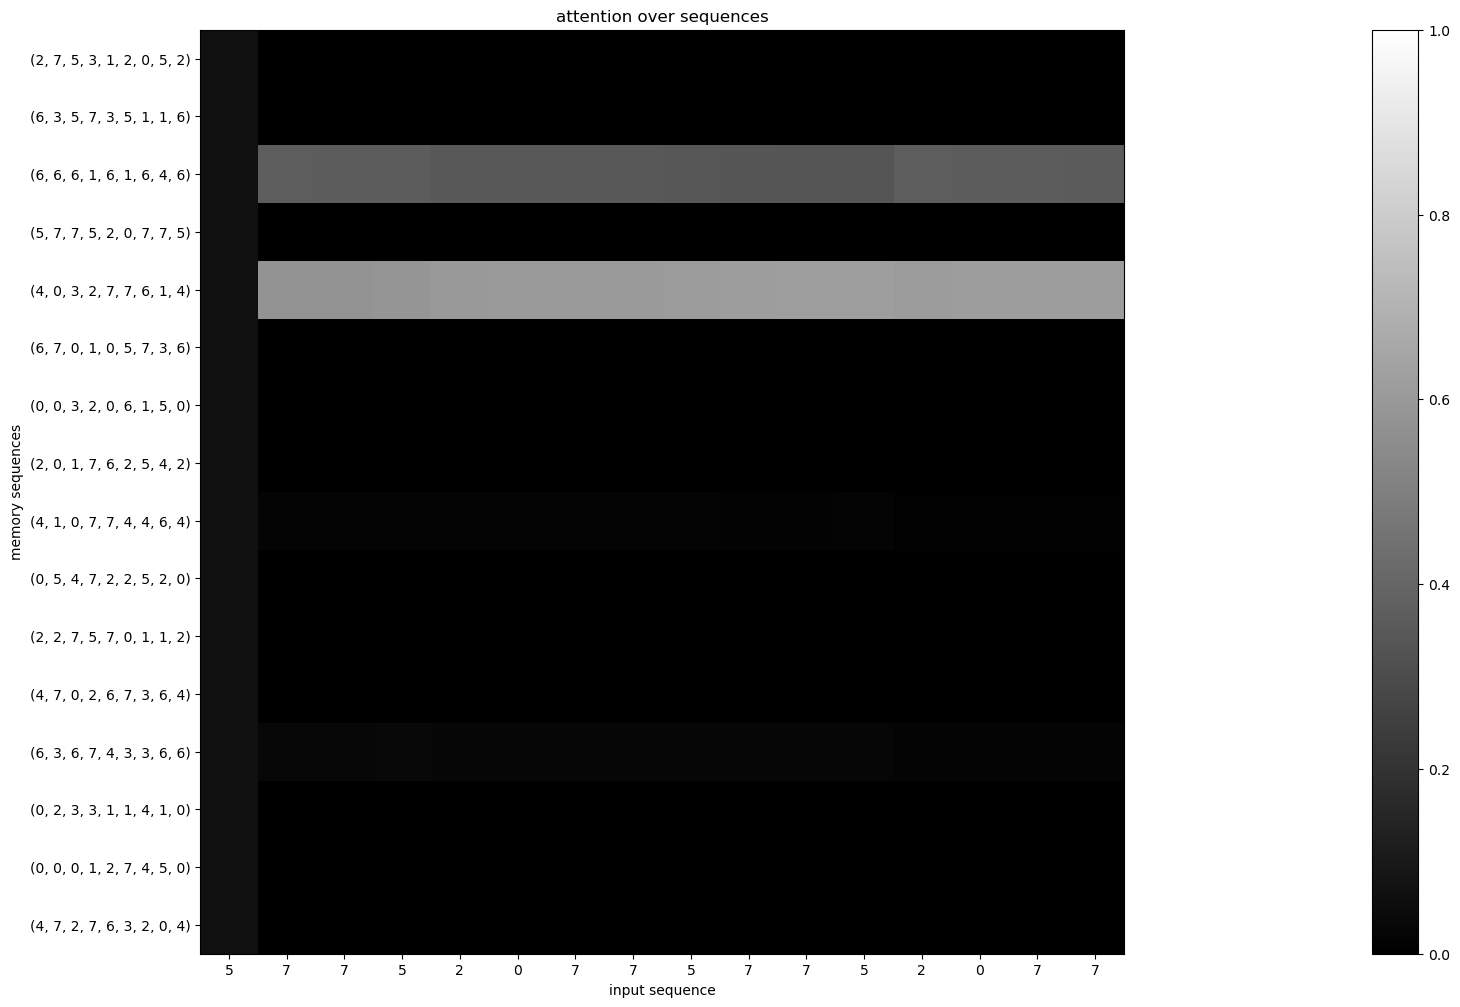

In [202]:
for idx in range(4):
    plot_attention1(idx, train_seqs_x, train_seqs_y, mem_seqs_x, mem_seqs_y, memory_model11)